<h1 style="margin-bottom:0"><center>DI 504 - Foundations of Deep Learning</center></h1>
<h2 style="margin-top:0"><center>Term Project</center></h2>
<h3 style="margin-top:0"><center>Mert Mecit/ 2149219</center></h3>
<br>

First, I will import the libraries that will be used throughout the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In this part, I will explain the dataset I am using. This dataset is called AG News. This dataset is mainly used for classifying news based on its title and content. It classifies data into 4 categories:
1.	World
2.	Sports
3.	Business
4.	Sci/Tech.
	
It has three columns, class, title, and description (content). This dataset originally consists of more than 1 million news from more than 2000 resources and took 1 year to complete.

Before exploring it, I should mention that, for my analysis, I have combined title and description into one variable to save time and called it “Description”

In [2]:
df = pd.read_csv("train.csv")
df['Description'] = df['Title'] + " " + df['Description']
df = df.drop(['Title'], axis=1)
df = df.rename({'Class Index': 'Index', 'Description': 'Description'}, axis=1)
df.head(5)

,Index,Description
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


As you can see, it is a pretty simple dataset. It has index number and a description. Description consists of both title and content.

When we check the descriptive statistics of the variable index and value counts of the “description” value:

In [3]:
from collections import Counter
z = df.Index
Counter(z)

Counter({3: 30000, 4: 30000, 2: 30000, 1: 30000})

In [4]:
df['Words'] = df['Description'].str.split().str.len()
df.describe()

,Index,Words
count,120000.000000,120000.000000
mean,2.500000,37.844617
std,1.118039,10.088702
min,1.000000,4.000000
25%,1.750000,32.000000
50%,2.500000,37.000000
75%,3.250000,43.000000
max,4.000000,177.000000


Descriptive statistics here tells us important things here. First of all, these are the descriptive statistics for our train dataset. It consists of 120000 rows, which is good because, in deep learning models, we generally want to use a high amount of data. <br>

One important insight we can get from the table below is, all of our indexes have the same amount of data. This is crucial as if there were to be a significant imbalance, I needed to apply different methods that work well with imbalanced data or somehow (for example via augmentation) I would need to balance my data to proceed. <br>
    
The last thing I want to mention about the descriptive statistics is in the description part. We can see here, on average, I have 37 words in the description part. This can affect our runtimes significantly and compared to other datasets, we can say this is fairly low.


Now, we can proceed to build model.

First, I will import wandb.

In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: metromert (use `wandb login --relogin` to force relogin)


True

Now, we can create our data. 

In [6]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.columns = ['Index', 'Title', 'Text']
test_data.columns = ['Index', 'Title', 'Text']

X_train = train_data['Title'] + " " + train_data['Text'] 
y_train = train_data['Index'].apply(lambda x: x-1).values 

x_test = test_data['Title'] + " " + test_data['Text']
y_test = test_data['Index'].apply(lambda x: x-1).values 

Also, I will create a max_len variable that keeps maximum length for padding later.

In [7]:
max_len = X_train.map(lambda x: len(x.split())).max()

Now, we can proceed with preprocessing part. We will apply tokenization and padding here.

Tokenization is the process of breaking a whole text into smaller parts. It can be done in several ways. One can turn a paragraph into sentences, sentences into words, or words into letters. In our case, it is sentences into words. Also, punctuations are removed from the sentence.

To work properly, in a deep learning model, every input has to be in a similar shape and similar size. Padding is crucial in this case as it provided this. You can be sure that your inputs have a similar size. I padded them into their max values.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tok = Tokenizer(num_words=10000)
tok.fit_on_texts(X_train.values)

X_train = tok.texts_to_sequences(X_train)
x_test = tok.texts_to_sequences(x_test)

X_train = pad_sequences(X_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

Start our wandb run.

In [9]:
WANDB_CONFIG = {
     'competition': 'AG News Classification Dataset', 
              '_wandb_kernel': 'neuracort'
    }

run = wandb.init(project='ag-news', config= WANDB_CONFIG)

Now, we create our model. Why the specific layers are chosen is written on the project report in a great detail.

In [10]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Model, Sequential

model = Sequential([
        Embedding(10000, 32, input_length = max_len),
        Bidirectional(LSTM(128, return_sequences = True)),
        Bidirectional(LSTM(64, return_sequences = True)),
        GlobalMaxPooling1D(),
        Dense(1024),
        Dropout(0.5),
        Dense(512),
        Dropout(0.5),
        Dense(256),
        Dropout(0.5),
        Dense(128),
        Dropout(0.5),
        Dense(64),
        Dropout(0.5),
        Dense(32),
        Dropout(0.5),
        Dense(16),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

I also added an early stopping mechanism. This will stop the training process whenever it does not see a significant improvement in validation error.

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        min_delta=1e-3
    ),
    WandbCallback()
]

Now, I start the training process.

In [12]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', 
              metrics=['accuracy']) 

history = model.fit(X_train, 
          y_train, 
          batch_size=1024, 
          validation_data=(x_test, y_test), 
          epochs=10, 
          callbacks=callbacks)

wandb.finish()

Epoch 1/10
118/118 [==============================] - 1683s 14s/step - loss: 1.0296 - accuracy: 0.5167 - val_loss: 0.3429 - val_accuracy: 0.8951
Epoch 2/10
118/118 [==============================] - 2171s 18s/step - loss: 0.4482 - accuracy: 0.8600 - val_loss: 0.3033 - val_accuracy: 0.9079


accuracy,▁█
epoch,▁█
loss,█▁
val_accuracy,▁█
val_loss,█▁
accuracy,0.85998
best_epoch,1
best_val_loss,0.30331
epoch,1
loss,0.44824
val_accuracy,0.90789


Now, I will upload the model with the best weights (thanks to wandb!).

In [14]:
model.load_weights('model-best.h5')
model.save('model.hdf5')

First, I draw my accuracy and loss graphs. Note that it is not much informative because our model ended in just 2 epochs based on our early stopping mechanism.

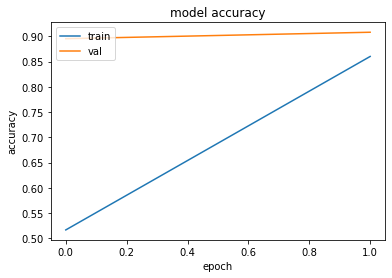

In [25]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

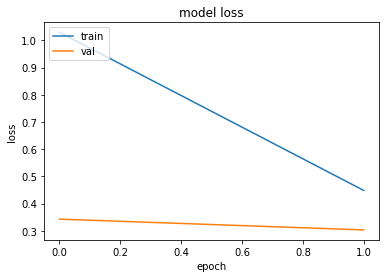

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

As we can see, even with 2 epochs, we improved our accuracy and decreased the losses significantly.

Lets draw a confusion matrix.

<Figure size 432x288 with 0 Axes>

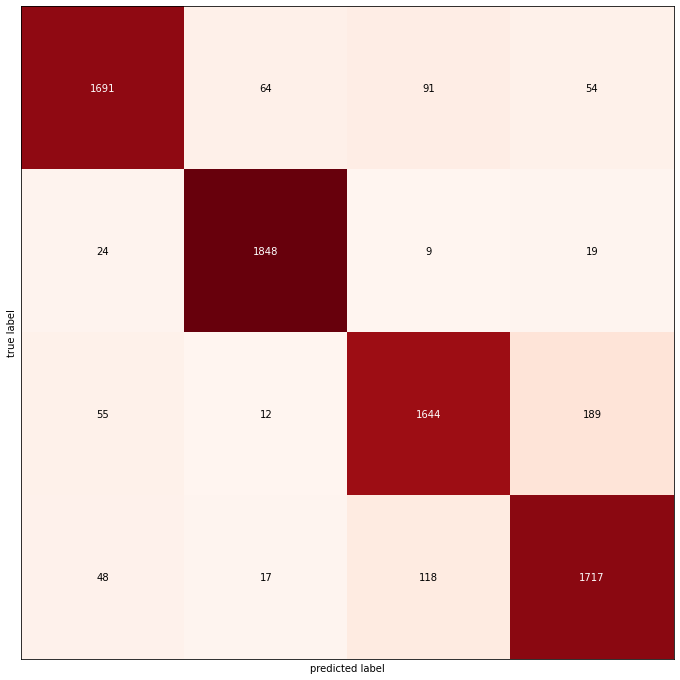

In [15]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

preds = [np.argmax(i) for i in model.predict(x_test)]
cm  = confusion_matrix(y_test, preds)
plt.figure()
plot_confusion_matrix(cm, figsize=(16,12), hide_ticks=True, cmap=plt.cm.Reds)
plt.show()

In world and sports news, the model performs better. Especially in sci/tech news, it performs with an 80% accuracy. However, this can be expected as to whether a sci/tech news is related to business or world is generally cannot be understood easily. Also, sports news are the ones that are barely falsely predicted and this is logical as we generally tend to not confuse sports news with business or sci/tech.

Finally, we can look at some numbers to understand our accuracies.

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score

print("Recall of the model is {:.2f}".format(recall_score(y_test, preds, average='micro')))
print("Precision of the model is {:.2f}".format(precision_score(y_test, preds, average='micro')))
print("Accuracy of the model is {:.2f}".format(accuracy_score(y_test, preds)))

Recall of the model is 0.91
Precision of the model is 0.91
Accuracy of the model is 0.91


Recall or correctly predicted positive observations to all observations in the class, precision or positive observations on total positive predictions and accuracy, a weighted average of recall and precision all come out to be 0.91.

Now, I will create a function that I may use for predicting text I create or find online.

In [17]:
def exampler(text):

    categories = ['World', 'Sports', 'Business', 'Sci-Tech']
    
    test_seq = pad_sequences(tok.texts_to_sequences(text), maxlen=max_len)

    test_preds = [categories[np.argmax(i)] for i in model.predict(test_seq)]

    for news, label in zip(text, test_preds):
        print('{}'.format(label))

In [18]:
exampler(['Eminem Terrified As Daughter Begins Dating Man Raised On His Music'])

World


In [19]:
exampler(['7 Ways to Make Money While Waiting for Disability Benefits'])

Business


In [20]:
exampler(['10 Signs That You Will NOT Make It As A Successful Photographer'])

World


In [21]:
exampler(['Winter Olympics quiz: Test your knowledge of the Games'])

Sci-Tech


Although the difference between some categories is not crystal clear, I think the first, second, and last ones are definitely correctly labeled. However, the third one is ambiguous. It can be world, business, or even sci/tech to some extent.